In [601]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
k = tf.keras

In [602]:
df = pd.read_csv('./RSCCASN.csv', parse_dates=True, index_col='DATE')
df.head()

,RSCCASN
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558


In [603]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 334 entries, 1992-01-01 to 2019-10-01
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   RSCCASN  334 non-null    int64
dtypes: int64(1)
memory usage: 5.2 KB


In [604]:
train = df[:316]

In [605]:
test = df[-18:]

In [606]:
train

,RSCCASN
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558
...,...
2017-12-01,33720
2018-01-01,15881
2018-02-01,18585


In [607]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(train)
scaled_test = scaler.transform(test)

In [608]:
length = 12

In [609]:
generator = k.preprocessing.sequence.TimeseriesGenerator(scaled_train, scaled_train, length=length, batch_size=1)

In [610]:
generator[0]

(array([[[0.        ],
         [0.02127505],
         [0.05580163],
         [0.08942056],
         [0.09512053],
         [0.08146965],
         [0.07860151],
         [0.12979233],
         [0.09566512],
         [0.1203892 ],
         [0.15426227],
         [0.41595266]]]),
 array([[0.02047633]]))

In [611]:
model = k.Sequential()
model.add(k.layers.LSTM(100, activation='relu', recurrent_initializer='glorot_uniform', input_shape=(length, 1)))
model.add(k.layers.Dense(1))
model.compile(optimizer='adam', loss='mse')

In [612]:
callback = k.callbacks.EarlyStopping(patience=5)

In [613]:
validation_generator = k.preprocessing.sequence.TimeseriesGenerator(scaled_test, scaled_test, length=length, batch_size=1)

In [614]:
model.fit(generator, epochs=20, callbacks=[callback], validation_data=validation_generator)

Epoch 1/20


2023-05-15 15:01:56.818466: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


304/304 [==============================] - ETA: 0s - loss: 0.0246

2023-05-15 15:01:59.958514: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


304/304 [==============================] - 3s 7ms/step - loss: 0.0246 - val_loss: 0.0091
Epoch 2/20
304/304 [==============================] - 2s 5ms/step - loss: 0.0153 - val_loss: 0.0024
Epoch 3/20
304/304 [==============================] - 2s 6ms/step - loss: 0.0115 - val_loss: 0.0037
Epoch 4/20
304/304 [==============================] - 2s 5ms/step - loss: 0.0045 - val_loss: 6.2126e-04
Epoch 5/20
304/304 [==============================] - 2s 5ms/step - loss: 0.0034 - val_loss: 4.7220e-04
Epoch 6/20
304/304 [==============================] - 2s 6ms/step - loss: 0.0016 - val_loss: 4.2451e-04
Epoch 7/20
304/304 [==============================] - 2s 6ms/step - loss: 0.0018 - val_loss: 3.5749e-04
Epoch 8/20
304/304 [==============================] - 1s 5ms/step - loss: 0.0015 - val_loss: 5.5542e-04
Epoch 9/20
304/304 [==============================] - 1s 4ms/step - loss: 0.0021 - val_loss: 2.5487e-04
Epoch 10/20
304/304 [==============================] - 1s 4ms/step - loss: 0.0016 - val

<Axes: >

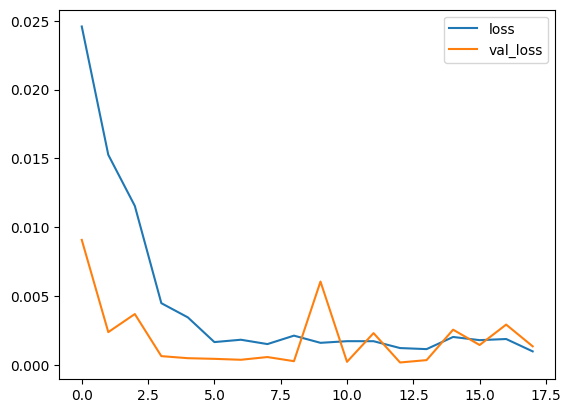

In [615]:
pd.DataFrame(model.history.history).plot()

In [616]:
test_predictions = []
batch_test = scaled_train[-length:].reshape(1, length, 1)
for _ in range(len(test)):
    predicted = model.predict(batch_test)
    test_predictions.append(predicted)
    batch_test = np.append(batch_test[:, 1:, :], [predicted], axis=1)

1/1 [==============================] - 0s 19ms/step


In [617]:
test_predictions = np.array(test_predictions).reshape(-1, 1)

In [618]:
test_predictions = scaler.inverse_transform(test_predictions)

In [619]:
df_test_predictions = pd.DataFrame(test_predictions, index=test.index, columns=['prediction'])

<Axes: xlabel='DATE'>

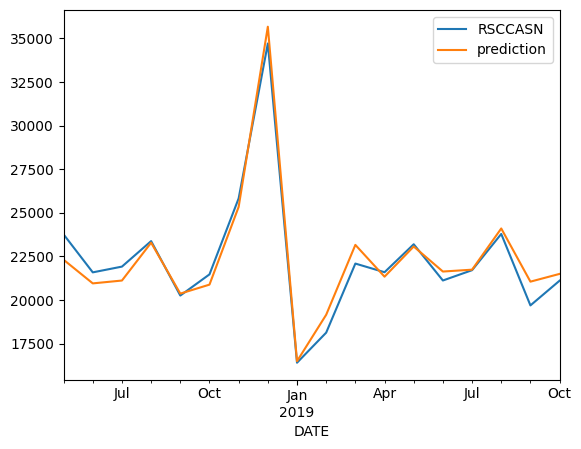

In [620]:
ax = test.plot()
df_test_predictions.plot(ax=ax)

In [702]:
full_scaler = MinMaxScaler()
full_data_scaled = full_scaler.fit_transform(df)

In [703]:
full_generator = k.preprocessing.sequence.TimeseriesGenerator(full_data_scaled, full_data_scaled, length, batch_size=1)

In [704]:
model = k.Sequential()
model.add(k.layers.LSTM(100, activation='relu', recurrent_initializer='glorot_uniform', input_shape=(length, 1)))
model.add(k.layers.Dense(1))
model.compile(optimizer='adam', loss='mse')

In [705]:
model.fit_generator(full_generator, epochs=7)

Epoch 1/7


/tmp/ipykernel_29619/3841076844.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(full_generator, epochs=7)
2023-05-15 15:31:01.389891: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


322/322 [==============================] - 4s 6ms/step - loss: 0.0260
Epoch 2/7
322/322 [==============================] - 2s 7ms/step - loss: 0.0164
Epoch 3/7
322/322 [==============================] - 2s 5ms/step - loss: 0.0107
Epoch 4/7
322/322 [==============================] - 2s 6ms/step - loss: 0.0066
Epoch 5/7
322/322 [==============================] - 2s 6ms/step - loss: 0.0029
Epoch 6/7
322/322 [==============================] - 2s 6ms/step - loss: 0.0021
Epoch 7/7
322/322 [==============================] - 2s 6ms/step - loss: 0.0014


In [706]:
forcast = []
batch_to_pred = full_data_scaled[-length:].reshape(1, length, 1)
for i in range(length):
    pred = model.predict(batch_to_pred)
    forcast.append(pred)
    batch_to_pred = np.append(batch_to_pred[:, 1:, :], [pred], axis=1)


1/1 [==============================] - 0s 22ms/step


In [707]:
forcast = np.array(forcast).reshape(1, -1)
forcast = full_scaler.inverse_transform(forcast)

In [714]:
df.iloc[-1]

RSCCASN    21113
Name: 2019-10-01 00:00:00, dtype: int64

In [738]:
index_df = pd.date_range(start='2019-11-01', freq='MS', periods=length)

In [739]:
forcast

array([[27274.342, 37569.57 , 17004.318, 19044.51 , 22874.174, 22513.662,
        24169.625, 22093.309, 22746.574, 24902.15 , 20860.455, 22428.445]],
      dtype=float32)

In [740]:
index_df

DatetimeIndex(['2019-11-01', '2019-12-01', '2020-01-01', '2020-02-01',
               '2020-03-01', '2020-04-01', '2020-05-01', '2020-06-01',
               '2020-07-01', '2020-08-01', '2020-09-01', '2020-10-01'],
              dtype='datetime64[ns]', freq='MS')

In [741]:
forcast_df = pd.DataFrame(forcast[0], index=index_df, columns=['RSCCASN'])

<Axes: xlabel='DATE'>

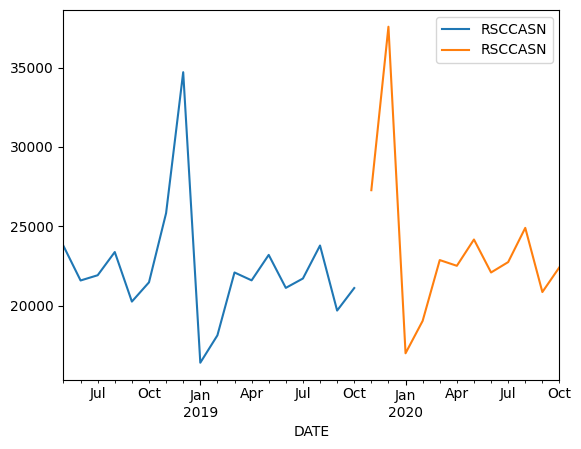

In [742]:
ax = df[-18:].plot()
forcast_df.plot(ax=ax)

<Axes: >

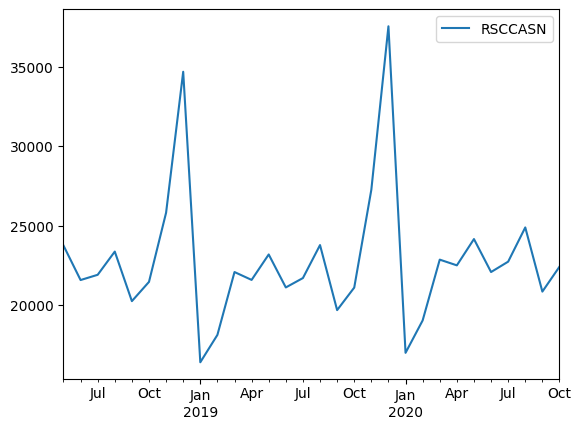

In [747]:
pd.concat([df[-18:], forcast_df]).plot()